<a href="https://colab.research.google.com/github/sreebalajisree/Fake_News_Detection/blob/main/fake_news_dectetion_BERT_tpu_New_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About this notebook


Other things to try:

Five-fold cross-mean fusion base 0.97709

Single Fold base 0.974

Five-fold cross-validation, weight fusion 0.9789

In-domain data further pre-training

1. Fine-tune warm_up 0.9794

2. dropout 0.9706

3. Utilize pseudo-tags

4. Label smoothing 0.9790

5: Add Indian language data

6: Five-fold cross-validation, average fusion 0.9814

7: Five-fold cross-validation, weight fusion 0.9789

8: single fold, average fusion

9: single fold, weight fusion, 10: length 130 0.978, 192 0.976



In [109]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [110]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
#Python libraries
import os
import copy
import random
from string import digits, punctuation
import re

#Basic EDA libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

#SK-learn libraries
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score, accuracy_score, classification_report

#Tensorflow libraries
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from gc import callbacks

#Transformer libraries
import transformers
from transformers import AutoModel
from transformers import BertTokenizer,BertModel,BertConfig,BertForPreTraining
from transformers import TFAutoModel, AutoTokenizer
from gc import callbacks

#Other NLP libraries
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from gensim.models.word2vec import Word2VecKeyedVectors

AUTO = tf.data.experimental.AUTOTUNE

In [112]:
transformers.__version__

'4.24.0'

In [113]:
fake_train_covid= pd.read_excel("/content/sample_data/data/Constraint_English_Train.xlsx")
fake_valid_covid = pd.read_excel("/content/sample_data/data/Constraint_English_Val.xlsx")
fake_test_covid = pd.read_excel("/content/sample_data/data/Constraint_English_Test_without_labels.xlsx")
fake_external1 = pd.read_excel("/content/sample_data/data/external_1.xlsx")
fake_external2 = pd.read_excel("/content/sample_data/data/external_2.xlsx")
df_pseudo = pd.read_csv("/content/sample_data/data/pseudo_submission.csv")
fake_train = pd.read_excel("/content/sample_data/data/new_train_data_all_topic.xlsx")
fake_valid = pd.read_excel("/content/sample_data/data/new_valid_data_all_topic.xlsx")
fake_test = pd.read_excel("/content/sample_data/data/new_test_data_all_topic.xlsx")

In [114]:
fake_train.head()

,tweet,label
0,Donald Trump Sends Out Embarrassing New Yearâ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obamaâ€™s Na...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [115]:
fake_valid.head()

,tweet,label
0,ULTIMATE HYPOCRITES! RUSSIAN Ambassador Visite...,0
1,WATCH: G.W. BUSH Gushes Over Kimmelâ€™s Anti-T...,0
2,RACIST LIBERAL REPORTER Arrested In Connection...,0
3,NEWT GINGRICH Punches Back At Democrats With M...,0
4,EXPOSED! OBAMA REGIME Gave MILLIONS US Tax Dol...,0


In [116]:
fake_test.head()

,tweet,label
0,NORDSTROM CANCELS IVANKA TRUMP BRAND After Lib...,0
1,BREAKING: IRAN Tests Cruise Missileâ€¦Trump WA...,0
2,WHAT? DEMOCRAT CONGRESSWOMAN Calls Violent Rio...,0
3,HILLARYâ€™S LAP DOG VA Senator Tim Kaine Calls...,0
4,SHOCKING MIGRANT CLASS WARS: N. African Migran...,0


In [117]:
df_pseudo.head()

,tweet,label
0,Our daily update is published. States reported...,real
1,Alfalfa is the only cure for COVID-19.,fake
2,President Trump Asked What He Would Do If He W...,fake
3,States reported 630 deaths. We are still seein...,real
4,This is the sixth time a global health emergen...,real


## Helper Functions

In [118]:
def seed_everything(seed=0):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASSEED'] = str(seed)
  os.environ['TF_DETERMINSTIC_OPS'] = '1'
  random.seed(seed)

seed=1024
seed_everything(seed)



In [119]:
def fast_encode(texts, tokenizers, chunk_size=256, maxlen=512):
  """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
  """
  tokenizer.enable_truncation(max_length=maxlen)
  tokenizer.enable_padding(max_length=maxlen)
  all_ids = []

  for i in tqdm(range(0, len(texts), chunk_size)):
    text_chunk = texts[i:i+chunk_size].tolist()
    encs = tokenizer.encode_batch(text_chunk)
    all_ids.extend([enc.ids for enc in encs])
  
  return np.array(all_ids)

In [120]:
def regular_encode(texts, tokenizer, maxlen=512):
  encod_dic = tokenizer.batch_encode_plus(texts, return_token_type_ids=False, pad_to_max_length=True, max_length = maxlen)
  return np.array(encod_dic['input_ids'])

In [121]:
def build_model(transformer, max_len=512):
  """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
  """
  input_words_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_words_ids")
  sequence_output = transformer(input_words_ids)[0]
  cls_token = sequence_output[:, 0, :]
  output = Dense(2, activation='softmax')(cls_token)

  model = Model(inputs = input_words_ids, outputs=output)
  model.compile(Adam(lr=5e-6), loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01), metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, average='weighted')])

  return model


In [122]:
#Data preprocessing

def data_process(data):
  for i, label in enumerate(data['label']):
    if(data['label'][i] == "real"):
      data['label'][i] = 1
    else:
      data['label'][i] = 0

In [123]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## TPU Configs

In [124]:
# Detect hardware, return appropriate distribution strategy
#Call the necessary code for tpu

try:
  # TPU detection. No parameters necessary if TPU_NAME environment variable is set
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  print("Running on TPU: ", tpu.master())
except ValueError:
  tpu = None

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
else:
  # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
  strategy = tf.distribute.get_strategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU:  grpc://10.36.232.42:8470


REPLICAS:  8


In [125]:
AUTO = tf.data.experimental.AUTOTUNE

# 50% cross validation
#5 fold cross validation
kfold = KFold(n_splits = 5, random_state = seed, shuffle=True)

#Parameter Configuration

In [126]:
# Configuration
epochs = 10
batch_size = 5 * (strategy.num_replicas_in_sync)
max_len = 140
use_external1 = False
use_external2 = True
use_pseudo = True
use_valid = True
display_plot = True


In [127]:
df_pseudo = pd.concat([df_pseudo['tweet'], df_pseudo['label']], axis=1)
data_process(df_pseudo)

In [128]:
fake_train1 = pd.concat([fake_train['tweet'], fake_train['label']], axis=1)
fake_valid1 = pd.concat([fake_valid['tweet'], fake_valid['label']], axis=1)

if (use_valid):
  fake_train1 = pd.concat([fake_train1, fake_valid1], ignore_index=True)

In [129]:
fake_train1.label.value_counts()

0    27482
1    25797
Name: label, dtype: int64

In [130]:
df_pseudo.head()

,tweet,label
0,Our daily update is published. States reported...,1
1,Alfalfa is the only cure for COVID-19.,0
2,President Trump Asked What He Would Do If He W...,0
3,States reported 630 deaths. We are still seein...,1
4,This is the sixth time a global health emergen...,1


## Load text data into memory

## Build datasets objects

In [131]:
def get_train_dataset(x_data, y_data):
  dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
  dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.shuffle(seed)
  dataset = dataset.cache()
  dataset = dataset.prefetch(AUTO)
  return dataset

def get_valid_dataset(x_data, y_data):
  dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
  dataset = dataset.batch(batch_size)
  dataset = dataset.cache()
  dataset = dataset.prefetch(AUTO)
  return dataset

Learning rate result: 1e-06 to 5e-05 to 4.14e-06


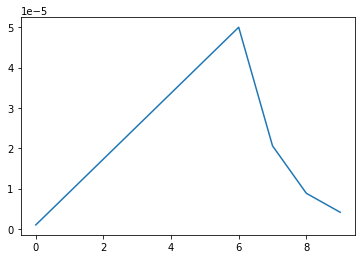

In [132]:
# cosine decay with warm_up
lr_start = 0.00000
lr_max = 0.00005
lr_min = lr_start = 0.000001
lr_rampup_epochs = 6
lr_sustain_epochs = 0
lr_exp_decay = .4

def lr_func(epochs):
  if epochs < lr_rampup_epochs:
    learning_rate = (lr_max - lr_start) / lr_rampup_epochs * epochs + lr_start
  elif epochs < lr_rampup_epochs + lr_sustain_epochs:
    learning_rate = lr_max
  else:
    learning_rate = (lr_max - lr_min) * lr_exp_decay ** (epochs - lr_rampup_epochs - lr_sustain_epochs) + lr_min
  return learning_rate


new_epochs_range = [i for i in range(epochs)]
learning_rate_result = [lr_func(x) for x in new_epochs_range]
print("Learning rate result: {:.3g} to {:.3g} to {:.3g}".format(learning_rate_result[0], max(learning_rate_result), learning_rate_result[-1]))
#plt.xticks(new_epochs_range, "Number of Epochs")
#plt.yticks(learning_rate_result, "Learning rate")
plt.plot(new_epochs_range, learning_rate_result)
plt.show()



In [133]:
lr_warm_up = tf.keras.callbacks.LearningRateScheduler(lr_func, verbose=1)

## Load model into the TPU

## Train Model

First, we train on the subset of the training set, which is completely in English.

#### FOLD 1
use pseudo


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  supe


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/10


1119/1119 [==============================] - 208s 116ms/step - loss: 0.4843 - accuracy: 0.7519 - f1_score: 0.7517 - val_loss: 0.2467 - val_accuracy: 0.9060 - val_f1_score: 0.9060 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/10
1119/1119 [==============================] - 116s 103ms/step - loss: 0.1741 - accuracy: 0.9388 - f1_score: 0.9388 - val_loss: 0.1161 - val_accuracy: 0.9691 - val_f1_score: 0.9691 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/10
1119/1119 [==============================] - 117s 104ms/step - loss: 0.1004 - accuracy: 0.9723 - f1_score: 0.9723 - val_loss: 0.1235 - val_accuracy: 0.9700 - val_f1_score: 0.9700 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/10
1119/1119 [==============================] - 116s 104ms/step - loss: 0.0754 - accuracy: 0.9835 - f1_score: 0.9835 - val_loss: 0.0881 - va

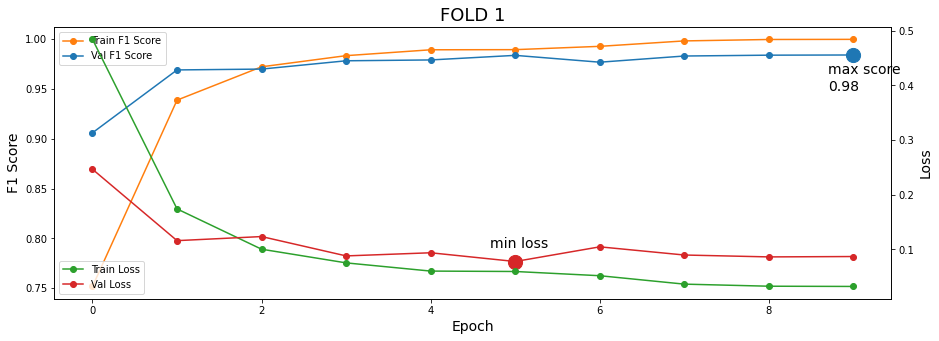

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### FOLD 2
use pseudo


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  supe


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/10


1119/1119 [==============================] - 206s 115ms/step - loss: 0.3985 - accuracy: 0.8074 - f1_score: 0.8075 - val_loss: 0.2141 - val_accuracy: 0.9175 - val_f1_score: 0.9175 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/10
1119/1119 [==============================] - 116s 103ms/step - loss: 0.1675 - accuracy: 0.9417 - f1_score: 0.9417 - val_loss: 0.1107 - val_accuracy: 0.9696 - val_f1_score: 0.9696 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/10
1119/1119 [==============================] - 116s 103ms/step - loss: 0.0949 - accuracy: 0.9750 - f1_score: 0.9750 - val_loss: 0.0838 - val_accuracy: 0.9813 - val_f1_score: 0.9813 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/10
1119/1119 [==============================] - 116s 104ms/step - loss: 0.0765 - accuracy: 0.9833 - f1_score: 0.9833 - val_loss: 0.0757 - va

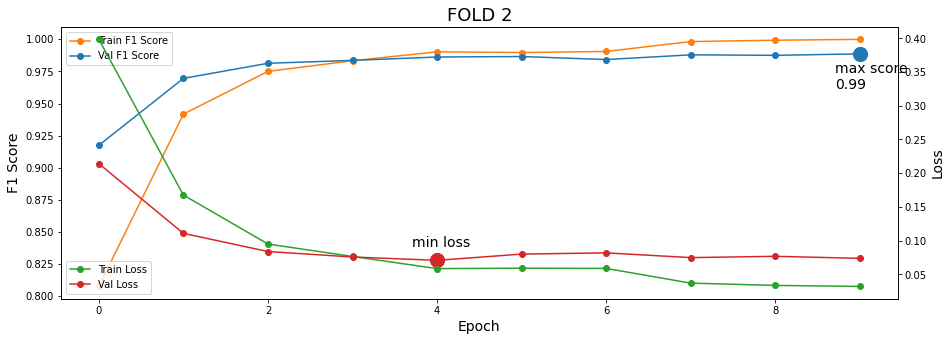

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### FOLD 3
use pseudo


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  supe


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/10


1119/1119 [==============================] - 209s 115ms/step - loss: 0.3851 - accuracy: 0.8169 - f1_score: 0.8168 - val_loss: 0.1941 - val_accuracy: 0.9326 - val_f1_score: 0.9326 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/10
1119/1119 [==============================] - 117s 105ms/step - loss: 0.1498 - accuracy: 0.9513 - f1_score: 0.9513 - val_loss: 0.1298 - val_accuracy: 0.9625 - val_f1_score: 0.9625 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/10
1119/1119 [==============================] - 117s 104ms/step - loss: 0.0908 - accuracy: 0.9766 - f1_score: 0.9766 - val_loss: 0.0861 - val_accuracy: 0.9811 - val_f1_score: 0.9811 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/10
1119/1119 [==============================] - 114s 102ms/step - loss: 0.0725 - accuracy: 0.9844 - f1_score: 0.9844 - val_loss: 0.1125 - va

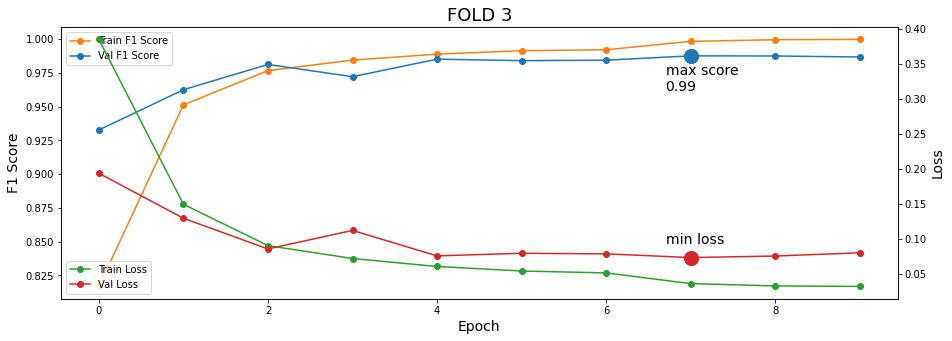

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### FOLD 4
use pseudo


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  supe


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/10


1119/1119 [==============================] - 211s 117ms/step - loss: 0.4220 - accuracy: 0.7897 - f1_score: 0.7897 - val_loss: 0.2040 - val_accuracy: 0.9227 - val_f1_score: 0.9227 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/10
1119/1119 [==============================] - 119s 106ms/step - loss: 0.1549 - accuracy: 0.9482 - f1_score: 0.9483 - val_loss: 0.0948 - val_accuracy: 0.9732 - val_f1_score: 0.9732 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/10
1119/1119 [==============================] - 116s 104ms/step - loss: 0.0955 - accuracy: 0.9752 - f1_score: 0.9752 - val_loss: 0.0812 - val_accuracy: 0.9811 - val_f1_score: 0.9811 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/10
1119/1119 [==============================] - 118s 105ms/step - loss: 0.0746 - accuracy: 0.9841 - f1_score: 0.9841 - val_loss: 0.0801 - va

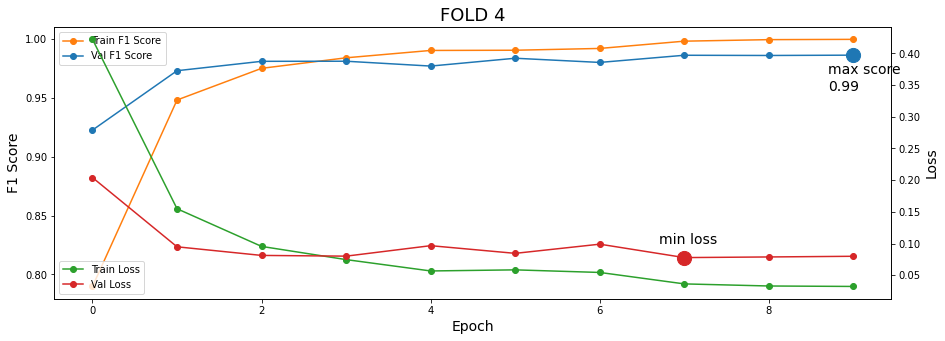

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### FOLD 5
use pseudo


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  supe


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/10


1119/1119 [==============================] - 210s 116ms/step - loss: 0.4288 - accuracy: 0.7893 - f1_score: 0.7891 - val_loss: 0.2032 - val_accuracy: 0.9280 - val_f1_score: 0.9280 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/10
1119/1119 [==============================] - 116s 104ms/step - loss: 0.1576 - accuracy: 0.9469 - f1_score: 0.9469 - val_loss: 0.0994 - val_accuracy: 0.9723 - val_f1_score: 0.9723 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/10
1119/1119 [==============================] - 116s 104ms/step - loss: 0.0936 - accuracy: 0.9756 - f1_score: 0.9756 - val_loss: 0.0801 - val_accuracy: 0.9828 - val_f1_score: 0.9828 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/10
1119/1119 [==============================] - 115s 103ms/step - loss: 0.0699 - accuracy: 0.9859 - f1_score: 0.9859 - val_loss: 0.0775 - va

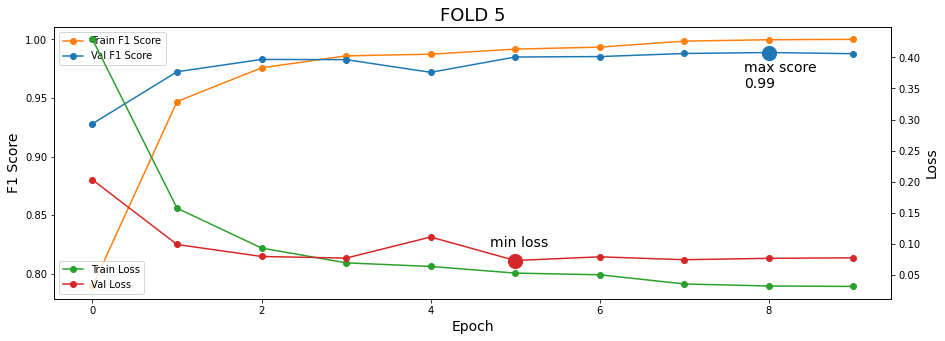

In [134]:
preds = []
weights = []
models = ["bert-base-uncased","distilroberta-base","nghuyong/ernie-2.0-en","bert-base-cased","distilbert-base-uncased"]
for fold,(train,valid) in enumerate(kfold.split(fake_train1.tweet,fake_train1.label)):
    print('#### FOLD',fold+1)
    x_train,x_valid,y_train,y_valid = fake_train1.tweet[train],fake_train1.tweet[valid]\
    ,fake_train1.label[train],fake_train1.label[valid]
    if (use_pseudo):
        print("use pseudo")
        x_train = pd.concat([x_train, df_pseudo.tweet]).reset_index(drop=True)
        y_train = pd.concat([y_train, df_pseudo.label]).reset_index(drop=True)
    if (use_external2):
        x_train = pd.concat([x_train, fake_external2.tweet]).reset_index(drop=True)
        y_train = pd.concat([y_train, fake_external2.label]).reset_index(drop=True)
    
    x_train = x_train.tolist()
    y_train = y_train.tolist()
    y_valid = y_valid.tolist()
    x_valid = x_valid.tolist()

    
    tokenizer = AutoTokenizer.from_pretrained(models[0])
    
    x_fake_train = regular_encode(x_train,tokenizer, maxlen=max_len)
    x_fake_valid = regular_encode(x_valid,tokenizer,maxlen=max_len)

    y_fake_train = to_categorical(y_train,dtype='int32')
    y_fake_valid = to_categorical(y_valid,dtype='int32')

    print(y_fake_train[0:5])
    print(y_fake_valid[0:5])
    
    train_dataset = get_train_dataset(x_fake_train,y_fake_train)
    valid_dataset = get_valid_dataset(x_fake_valid,y_fake_valid)
    
    
    n_steps = x_fake_train.shape[0] // batch_size

    # BUILD MODEL
    K.clear_session()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    with strategy.scope():
        transformer_layer = TFAutoModel.from_pretrained(models[0])
        model = build_model(transformer_layer, max_len=max_len)
    
    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_f1_score', verbose=0, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
    cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_f1_score', factor = 0.1, patience = 2, verbose = 2, min_delta = 0.0001, mode = 'max')
    
    train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    callbacks = [cb_lr_schedule,sv,lr_warm_up],
    validation_data= valid_dataset, epochs=epochs)
    
    
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)

    fake_train1_list = fake_train1['tweet'].tolist()
    fake_test_list = fake_test['tweet'].tolist()

    print("Type of fake_train1_list: ", type(fake_train1_list))
    print("Type of fake_test_list: ", type(fake_test_list))
    
        
    x_full_train = regular_encode(fake_train1_list, tokenizer, maxlen=max_len)
    
    
    weights.append(model.evaluate(valid_dataset)[2])
    x_fake_test = regular_encode(fake_test_list,tokenizer,maxlen=max_len)
    preds.append(model.predict(x_fake_test))
    
    
    if display_plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(epochs),train_history.history['f1_score'],'-o',label='Train F1 Score',color='#ff7f0e')
        plt.plot(np.arange(epochs),train_history.history['val_f1_score'],'-o',label='Val F1 Score',color='#1f77b4')
        x = np.argmax( train_history.history['val_f1_score'] ); y = np.max( train_history.history['val_f1_score'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max score\n%.2f'%y,size=14)
        plt.ylabel('F1 Score',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(epochs),train_history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(epochs),train_history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( train_history.history['val_loss'] ); y = np.min( train_history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i'%(fold+1),size=18)
        plt.legend(loc=3)
        plt.show()  
        
    del model

In [135]:
def weight_ensemble(weights,predictions):
    weight_sum = np.sum(weights)  
    prediction_sum = 0
    for i in range(len(weights)):
        prediction_sum += (weights[i]/weight_sum)*predictions[i]
    print(prediction_sum)
    np.savez('model_predict_weight',prediction_sum)
    result = np.argmax(prediction_sum,axis=1)
    return result

In [136]:
def mean_ensemble(predictions):
    result = np.argmax(np.mean(predictions,axis=0),axis=1)
    np.savez('model_predict_mean',np.mean(predictions,axis=0))
    return result

In [137]:
weight_result= weight_ensemble(weights,preds)

[[0.9966115  0.00338851]
 [0.99585587 0.00414415]
 [0.9955608  0.00443918]
 [0.99564654 0.00435347]
 [0.9955962  0.00440387]
 [0.9956272  0.0043727 ]
 [0.9958035  0.00419653]
 [0.99572456 0.00427545]
 [0.9955741  0.00442594]
 [0.9956231  0.00437693]
 [0.995583   0.00441696]
 [0.99548054 0.00451941]
 [0.9959594  0.00404064]
 [0.9956845  0.00431545]
 [0.9963603  0.00363974]
 [0.9956436  0.00435637]
 [0.99614817 0.00385179]
 [0.99566823 0.00433183]
 [0.9956429  0.00435708]
 [0.99548554 0.00451443]
 [0.9958239  0.00417609]
 [0.99565446 0.0043455 ]
 [0.99564034 0.00435974]
 [0.9955714  0.00442861]
 [0.99539614 0.00460388]
 [0.9957232  0.00427687]
 [0.9955379  0.00446206]
 [0.9956511  0.0043489 ]
 [0.99561334 0.00438676]
 [0.9956995  0.00430055]
 [0.9956962  0.0043038 ]
 [0.9956763  0.00432366]
 [0.99569446 0.00430555]
 [0.99564683 0.00435319]
 [0.9956268  0.0043732 ]
 [0.9955101  0.00448992]
 [0.99544865 0.00455139]
 [0.99535155 0.00464845]
 [0.9952966  0.00470341]
 [0.9958006  0.00419935]


In [138]:
data1 = np.load('./model_predict_weight.npz')

In [151]:
print("training set size: ", fake_train.shape)
print("test set size: ", fake_test.shape)
print("valid set size: ", fake_valid.shape)

training set size:  (40137, 2)
test set size:  (200, 2)
valid set size:  (13142, 2)


In [154]:
mean_result = mean_ensemble(preds)
f1_Score= f1_score(np.array(fake_test.label,dtype='int32'),mean_result,average='weighted')
f1_Score

0.9949998749968749

In [156]:
result = np.argmax(preds[4],axis=1)
f1_score(np.array(fake_test.label,dtype='int32'),result,average='weighted')

0.9949998749968749

In [157]:
def make_submission(result):
    submission = pd.DataFrame(columns=['id','label'])
    submission.label = result
    nlist = range(1,result.shape[0]+1)
    submission.id = nlist
    submission.to_csv('answer.txt', index=False)

In [158]:
make_submission(weight_result)

In [159]:
make_submission(mean_result)

In [160]:
x

5

In [161]:
submission = pd.DataFrame(columns=['id','label'])
submission.label = weight_result
nlist = range(1,weight_result.shape[0]+1)
submission.id = nlist
submission.to_csv('answer.txt', index=False)

In [162]:

MODEL = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

fake_valid_list = fake_valid['tweet'].tolist()

x_fake_valid = regular_encode(fake_valid_list,tokenizer,maxlen=max_len)
x_fake_train = regular_encode(fake_train1_list,tokenizer,maxlen=max_len)



y_fake_train = to_categorical(fake_train1.label,2,dtype='int32')
y_fake_valid = to_categorical(fake_valid1.label,2,dtype='int32')

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=max_len)
model.summary()
n_steps = x_fake_train.shape[0] // batch_size

train_dataset = get_train_dataset(x_fake_train,y_fake_train)
valid_dataset = get_valid_dataset(x_fake_valid,y_fake_valid)
cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_f1_score', factor = 0.5, patience = 3, verbose = 1, min_delta = 0.0001, mode = 'max')
sv = tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5', monitor='val_f1_score', verbose=0, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    callbacks = [cb_lr_schedule,lr_warm_up,sv],
    validation_data= valid_dataset,
    epochs=epochs
    )
print('Loading best model...')
model.load_weights('best_model.h5')
x_fake_test = regular_encode(fake_valid_list,tokenizer,maxlen=max_len)
score = model.evaluate(valid_dataset)
pred = model.predict(x_fake_test)
np.savez('single-model',pred)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFD

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_words_ids (InputLayer  [(None, 140)]            0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 140,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_1   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_1 (Dense)             (None, 2)                 1538

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/10
1331/1331 [==============================] - 143s 70ms/step - loss: 0.4075 - accuracy: 0.8113 - f1_score: 0.8111 - val_loss: 0.2400 - val_accuracy: 0.9086 - val_f1_score: 0.9077 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.166666666666668e-06.
Epoch 2/10
1331/1331 [==============================] - 87s 65ms/step - loss: 0.1505 - accuracy: 0.9499 - f1_score: 0.9499 - val_loss: 0.0855 - val_accuracy: 0.9796 - val_f1_score: 0.9796 - lr: 9.1667e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.7333333333333336e-05.
Epoch 3/10
1331/1331 [==============================] - 85s 64ms/step - loss: 0.0957 - accuracy: 0.9743 - f1_score: 0.9743 - val_loss: 0.0613 - val_accuracy: 0.9884 - val_f1_score: 0.9884 - lr: 1.7333e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.5500000000000003e-05.
Epoch 4/10
1331/1331 [==============================] - 87s 65ms/step - loss: 

In [163]:
f1_score(np.array(fake_valid1.label,dtype='int32'),np.argmax(pred,axis=1),average='weighted')

1.0

In [164]:
precision_score(np.array(fake_valid1.label,dtype='int32'),np.argmax(pred,axis=1),average='weighted') 

1.0

In [165]:
recall_score(np.array(fake_valid1.label,dtype='int32'),np.argmax(pred,axis=1),average='weighted') 

1.0

In [166]:
accuracy_score(np.array(fake_valid1.label,dtype='int32'),np.argmax(pred,axis=1))

1.0

In [167]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(score[0],score[1]))

Test set
  Loss: 0.032
  Accuracy: 1.000


(0.0, 0.42626483775675295)

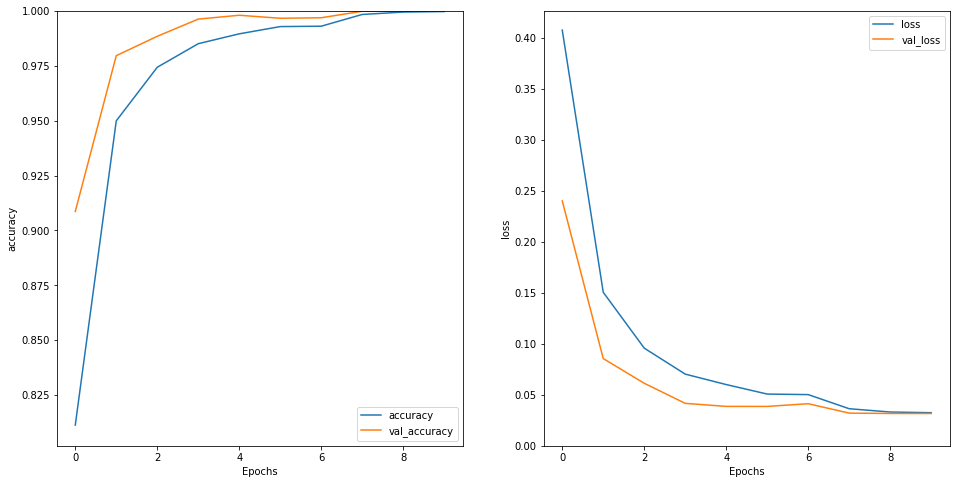

In [168]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(train_history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(train_history, 'loss')
plt.ylim(0, None)

In [169]:
y_valid_label_list = fake_valid1.label.to_list()
len(y_valid_label_list)

13142

#Classification Report

In [170]:
print(classification_report(y_valid_label_list, np.argmax(pred,axis=1), labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5474
           1       1.00      1.00      1.00      7668

    accuracy                           1.00     13142
   macro avg       1.00      1.00      1.00     13142
weighted avg       1.00      1.00      1.00     13142



#Confusion Matrix chart

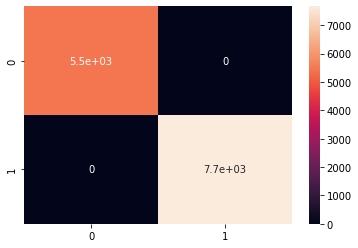

In [171]:
conf_mat = confusion_matrix(y_valid_label_list, np.argmax(pred,axis=1), labels=[0,1])
sns.heatmap(conf_mat, annot=True)

#Result prediction by the model for the given input from fake_test file

In [180]:
fake_external1[0:10]

,tweet,label
0,Travellers should adhere to strict hygiene mea...,1
1,For the first time in the post-war history of ...,1
2,"Be understing, a Japanese doctor offers excell...",0
3,"drinking lemon water could kill the virus, due...",0
4,Coronavirus Hoax: Fake Virus Pandemic Fabricat...,0
5,"In a very strage turn of events, renowned scie...",0
6,Frequent or excessive alcohol consumption can ...,1
7,As if we didn't have enough to worry about wit...,0
8,From conspiracy theory to geopolitical realism...,0
9,We don't know for certain. Based on the most r...,1


In [174]:
new_text = fake_external1['tweet'][0]
fake_test_list = [new_text]
x_fake_test_pred = regular_encode(fake_test_list,tokenizer,maxlen=max_len)

new_pred = model.predict(x_fake_test_pred)
labels = ['fake', 'real']

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


1/1 [==============================] - 0s 450ms/step


In [175]:
print(new_pred)
print(np.argmax(new_pred))
print(labels[np.argmax(new_pred)])

[[0.99637526 0.00362474]]
0
fake


In [176]:
print(new_text)

Travellers should adhere to strict hygiene measures, wash hands with soap and water regularly, and/or use alcohol-based hand sanitisers. Touching the face with unwashed hands should be avoided. Travellers should avoid contact with sick persons, in particular those with respiratory symptoms and fever. It should be emphasised that older people and those with underlying health conditions should take these precautionary measures very seriously. Travellers who develop any symptoms during or after travel should self-isolate; those developing acute respiratory symptoms within 14 days upon return should be advised to seek immediate medical advice, ideally by phone first to their national healthcare provider.


#Result prediction by the model for the input from fake_external1 file

In [177]:
new_text1 = fake_external1['tweet'][8]
fake_test_list1 = [new_text1]
x_fake_test_pred1 = regular_encode(fake_test_list1,tokenizer,maxlen=max_len)

new_pred1 = model.predict(x_fake_test_pred1)
labels = ['fake', 'real']

1/1 [==============================] - 0s 438ms/step


In [178]:
print(new_pred1)
print(np.argmax(new_pred1))
print(labels[np.argmax(new_pred1)])

[[0.9962171  0.00378297]]
0
fake


In [179]:
print(new_text1)

From conspiracy theory to geopolitical realism, the possibility to treat COVID-19 as a biological weapon has been finally accepted in the public sphere. The recent statement by the Chinese spokesman Zhao Lijian, formally accusing the US of bringing coronavirus to China, has highlighted a series of new opinions about the pandemic.The hypothesis of biological warfare behind the global pandemic had already been raised by Russian experts some weeks ago. Like any opinion that is slightly different from the official version of Western governments and their media agencies, the thesis was ridiculed and accused of being a “conspiracy theory”. However, as soon as the official spokesman for the Ministry of Foreign Affairs of the second largest economic power on the planet publishes a note attesting to this possibility, it leaves the sphere of “conspiracy theories” to enter the scene of public opinion and official government versions.In addition to making the explanation of biological warfare offi